# Generating fake data for neo4j analysis 

## Tasks 

* implement a way to test graph be

In [6]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import random as rd
from scipy.stats import poisson
import neo4j
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm

In [7]:
def get_table(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    elems = []
    for child in soup.find_all('table')[0].children:

        for some in child:
            row = []
            for i,td in enumerate(some):
                try:
                    row.append(td.text.replace('\n',""))
                except:
                    continue
                if len(row) > 0:
                    elems.append(row)

    return elems
    

table = get_table("https://www.zyxware.com/articles/4344/list-of-fortune-500-companies-and-their-websites")
subset = [[table[i][1],table[i][3], table[i][5]]   for i in range(0,len(table), 7)]
fortune_500 = pd.DataFrame(subset[1:], columns=subset[0])

In [8]:
#fortune_500.to_csv("fortune_500")

fortune_500 = pd.read_csv('fortune_500')

with open ('categories_tilt', 'rb') as fp:
    categories = pickle.load(fp)

with open ('purpose_tilt', 'rb') as fp:
    purpose = pickle.load(fp)

## Using the Python Driver

In [128]:
from neo4j import GraphDatabase

class exampleTilt:

    """
    class:  exampleTilt
    input:  - uri: bolt uri from neo4j
            - auth: credentials for neo4j
            - no_nodes: number of nodes to create 
            - comp_df:  dataframe with company names and websites
            - mu_poisson_*: average no. of samples for poisson distribution
            - reset: whether to delete all nodes in database (default False, meant for experimentation)

    """

    def __init__(self, uri, auth, no_nodes, comp_df, category_list, purpose_list, mu_poisson_dataDisclosed = 2,  mu_poisson_recipients = 2, reset = False, no_clusters = 5, cluster_weight = 3):
        self.driver = GraphDatabase.driver(uri, auth=auth)
        self.categories = category_list
        self.purposes = purpose_list
        self.reset = reset

        #number of nodes to push
        self.no_nodes = no_nodes
        
        #company names
        self.company_df = comp_df.head(no_nodes)

        #hyperparameters
        self.mu_poisson_dataDisclosed = mu_poisson_dataDisclosed
        self.mu_poisson_recipients = mu_poisson_recipients
        self.no_clusters = no_clusters
        
        #sort into fake clusters 
        self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]

        self.weight_scaler = cluster_weight
        self.same_cluster = [0, 0]


    def close(self):
        self.driver.close()

    # Create a person node.
    @classmethod
    def createTilt(cls, tx, id, comp_name, url, cluster):
        tx.run("MERGE (t:tilt {id: 0})-[:has_meta]->(m:meta {_id: $id, name: $company_name, created: $created, modified: $placeholder, version: $placeholder, language: $placeholder,  status: $placeholder, url: $url, cluster: $cluster, _hash: $placeholder}) ",
            id=id, 
            cluster = int(cluster),
            company_name = comp_name, 
            created = 3, #time.strftime("%Y:%m:%d, %H:%M:%S"),  we cannot use it with the merge statements because it makes the meta node unique. might have to come up with something here. placeholder it for now.
            url = url, 
            placeholder = 'None')
            
    def createDataDisclosed(self, tx,comp_name, _id, cluster):
        tx.run("MATCH (t:tilt)-[:has_meta]->(m:meta {name: $company_name}) "
               "MERGE (t)-[:has_dataDisclosed]->(d:dataDisclosed {_id: $_id, category: $placeholder, legalBases: $placeholder, legitimateInterests: $placeholder, nonDisclosure: $placeholder, storage: $placeholder}) "
               "MERGE (d)-[:has_purpose]->(p:purpose {purpose: $purpose, description: $placeholder}) ",
                company_name = comp_name, 
                purpose = rd.choice(self.purposes),
                _id=str(_id), 
                placeholder = 'Lorem Ipsum'      
        )

        # define weights dict
        weights = {}

        # fill with no of clusters 
        for n in range(self.no_clusters):
            weights[f'{n}'] = 1/self.no_clusters

        # increase weight for cluster of company
        weights[cluster] = weights[cluster]*self.weight_scaler  # another hyperparameter can be how much the weight is scaled

        # scale the weights
        scaled_weights = (pd.Series(weights) / self.company_df.cluster.value_counts(normalize=True))

        exclusion_list = [comp_name]

        # add recipients (as many as drawn from poisson)
        for _ in range(poisson.rvs(self.mu_poisson_recipients, size=1)[0]):
            self.same_cluster[1] += 1

            # select company to share info with df.loc[df['column_name'] == some_value]
            possible_comps = self.company_df.loc[~self.company_df['Company'].isin(exclusion_list)]
  
            shared_with_comp = possible_comps.sample(n=1, weights=possible_comps.cluster.map(scaled_weights))['Company'].values[0]

            if cluster == (possible_comps[possible_comps['Company'] == shared_with_comp]['cluster'].values[0]):
                self.same_cluster[0] += 1

            # create recipient
            tx.run("MATCH (d:dataDisclosed {_id: $_id}) " 
                    "MERGE (d)-[:has_recipient]->(r:recipient {name: $name, division: $placeholder, address: $placeholder, country: $placeholder, representative: $placeholder, email: $placeholder, phone: $placeholder, category: $placeholder}) ",
                    name = shared_with_comp,
                    placeholder = "Lorem Ipsum",
                    _id = str(_id)
                    )
            exclusion_list.append(shared_with_comp)

    # Match and display all friendships.
    def get_query(self, query):

        """
        get results of any query. 
        This is not part of any of the actual main methods but allows to query the graph using cypher

        """

        with self.driver.session(default_access_mode=neo4j.READ_ACCESS) as session_query:
            tx = session_query.begin_transaction()
            result = tx.run(query)
            tx.commit()
            tx.close()
        
        return result

    @classmethod
    def delete_nodes(cls, tx):
        tx.run("MATCH (n) detach delete n")

    
    def get_sorensen(self, tx, threshold = .99):
        out = tx.run(
                "MATCH (m_1:meta)-[:has_meta]-(t:tilt)-[:has_dataDisclosed]-(d:dataDisclosed)-[:has_recipient]-(r:recipient), (m:meta) "
                "WITH m_1, m, r, apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) as w "
                #"WITH apoc.text.levenshteinSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) AS w "
                f"WHERE w >= {threshold} "
                #"CREATE (m_1)-[c:has_sorensen]->(m) "
                #f"WHERE apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) >= {threshold} "
                            
                "CREATE (m_1)-[c:has_sorensen]->(m) "
                "SET c.weight = w "
                "RETURN COUNT(c)")

        print("Sorensen-relationships created:", out.single()[0])


    def main(self):
        saved_bookmarks = []  # To collect the session bookmarks

        if self.reset:
            with self.driver.session() as session_del:
                session_del.write_transaction(self.delete_nodes)
                saved_bookmarks.append(session_del.last_bookmark())
            print("Graph has been cleared")


        for i in tqdm(range(self.no_nodes)):
            
            with self.driver.session() as session_a: 
                session_a.write_transaction(self.createTilt, 
                                            str(self.company_df['Rank'][i]), 
                                            self.company_df['Company'][i], 
                                            self.company_df['Website'][i], 
                                            str(self.company_df['cluster'][i]))

                for d in range(poisson.rvs(self.mu_poisson_dataDisclosed, size=1)[0]):
                    session_a.write_transaction(self.createDataDisclosed, 
                                                self.company_df['Company'][i], 
                                                str(i)+str(d), str(self.company_df['cluster'][i]))
                saved_bookmarks.append(session_a.last_bookmark())

        print("recipients were created: ",self.same_cluster[1])

        with self.driver.session() as session_sorensen: 
            session_sorensen.write_transaction(self.get_sorensen)

            print(f"{self.same_cluster[0]/self.same_cluster[1]*100}% of recipients were in the same cluster")


In [129]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 2,
                    cluster_weight = 100,
                    reset=True)
fakeTilt.main()

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/3196366715.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


recipients were created:  114
Sorensen-relationships created: 114
94.73684210526315% of recipients were in the same cluster


## Using the GDS library for python

- documentation https://neo4j.com/docs/graph-data-science-client/current/getting-started/
- Louvain algorithm: https://www.youtube.com/watch?v=0zuiLBOIcsw


In [39]:
from graphdatascience import GraphDataScience

In [40]:
gds = GraphDataScience('bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema


### Analysis

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 18.73it/s]


recipients were created:  45
Sorensen-relationships created: 45
15.555555555555555% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.87it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  59
Sorensen-relationships created: 59
71.1864406779661% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.26it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  43
Sorensen-relationships created: 43
86.04651162790698% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 16.32it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  51
Sorensen-relationships created: 51
92.15686274509804% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 19.01it/s]


recipients were created:  42
Sorensen-relationships created: 42
85.71428571428571% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.39it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  57
Sorensen-relationships created: 57
91.22807017543859% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 16.79it/s]


recipients were created:  71
Sorensen-relationships created: 71
90.14084507042254% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.48it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  57
Sorensen-relationships created: 57
98.24561403508771% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.91it/s]


recipients were created:  51
Sorensen-relationships created: 51
96.07843137254902% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 19.19it/s]


recipients were created:  50
Sorensen-relationships created: 50
98.0% of recipients were in the same cluster


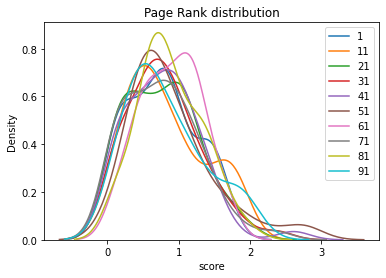

In [77]:
## Some analysis

rd.seed(10)

#set up outcome collectors
community_counts = []
community_dfs = []

recipient_in_cluster = []

#begin the figure
plt.figure()

#iterate through a hyper parameter: here how much do we increase the weight of same cluster nodes for recipient sharing
for prob_scale in range(1,100,10): #add the values to be iterated through

    # make an instance of a database
    fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 1,
                    cluster_weight = prob_scale,  ### Define the hyperparameter 
                    no_clusters=5,
                    reset=True) #reset has to be true so new graphs are created

    fakeTilt.main() #generate the graph

    recipient_in_cluster.append(fakeTilt.same_cluster[0]/fakeTilt.same_cluster[1])

    try: # get a projection of the graph 
        G,_ = gds.graph.project('prob_scale',
                            ['meta', 
                            #'dataDisclosed', 'tilt', 'recipient'
                                ], 
                            {#'has_meta': {"orientation": "UNDIRECTED"}, 
                            #'has_dataDisclosed': {"orientation": "UNDIRECTED"},
                            #'has_recipient': {"orientation": "UNDIRECTED"}, 
                            'has_sorensen': {"orientation": "UNDIRECTED"}}
                        )
    except: 
        G.drop() # if the projection already exists, delete it and make anew
        G,_ = gds.graph.project('prob_scale',
                            ['meta', 
                            #'dataDisclosed', 'tilt', 'recipient'
                                ], 
                            {#'has_meta': {"orientation": "UNDIRECTED"}, 
                            #'has_dataDisclosed': {"orientation": "UNDIRECTED"},
                            #'has_recipient': {"orientation": "UNDIRECTED"}, 
                            'has_sorensen': {"orientation": "UNDIRECTED"}}
                        )
    
    # run the louvain algorithm. 
    res = gds.louvain.mutate(G, mutateProperty = 'community', nodeLabels = ['meta'], tolerance = 10**(-5))
    
    # get the number of communities found
    community_counts.append(res['communityCount'])

    # collect the number of nodes in each community
    louvain_df = gds.graph.streamNodeProperty(G, 'community')
    community_dfs.append(louvain_df)
    
    #print(gds.graph.streamNodeProperties(G, ['community'], separate_property_columns=True))

    # plot a k-density plot of the page-rank distribution
    sns.kdeplot(gds.pageRank.stream(G)['score'], label = f"{prob_scale}")
    plt.title("Page Rank distribution")
    
    # delete the graph projection
    G.drop()

plt.legend()
plt.show()

In [84]:
print(len(np.unique(louvain_df['propertyValue'])))

14


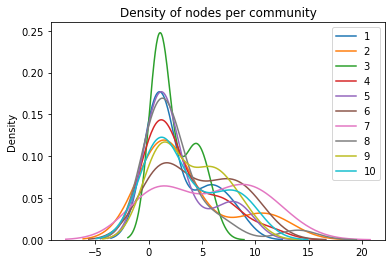

In [79]:
# plotting the number of community members 
plt.figure()

for it, df in enumerate(community_dfs):

    sns.kdeplot(df.value_counts('propertyValue'), label = f'{it+1}')

plt.title("Density of nodes per community")
plt.legend()
plt.show()

Text(0, 0.5, 'No. communities')

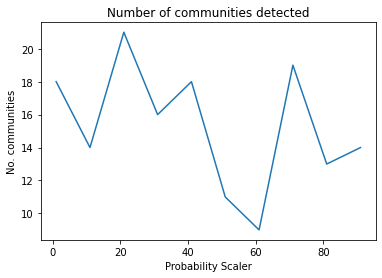

In [80]:
#plotting the number of communities 
plt.plot(range(1,100, 10), community_counts)
plt.title("Number of communities detected")
plt.xlabel("Probability Scaler")
plt.ylabel("No. communities")

In [81]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 100,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 1,
                    cluster_weight = 10**8,  ### Define the hyperparameter 
                    no_clusters=2,
                    reset=True) #reset has to be true so new graphs are created

fakeTilt.main() #generate the graph

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/313661213.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 100/100 [00:05<00:00, 17.60it/s]

recipients were created:  84
Sorensen-relationships created: 84
100.0% of recipients were in the same cluster


## Visuals

Use cypher queries to get an visualualise our database in directly in a jupyter notebook using graphistry

#### Doku
- https://hub.graphistry.com/docs/ui/index/
- https://github.com/graphistry/pygraphistry/blob/master/demos/demos_databases_apis/neo4j/official/graphistry_bolt_tutorial_public.ipynb
- https://hub.graphistry.com/

In [11]:
#!pip install --user graphistry

import graphistry

In [12]:
NEO4J = {
        'uri':'bolt://localhost:11003', 
        'auth' : ('neo4j', 'letmein')
}

graphistry.register(api=3, username='j_halkenhaeusser', password='longlivetransparency22', protocol='https', server='hub.graphistry.com')
graphistry.register(bolt=NEO4J)


In [15]:
graphistry.cypher("""
      match (m:meta)-[s:has_sorensen]-(n:meta), (t:meta) return t, m, s, n
  """).plot()

In [5]:
graphistry.cypher("""
      match (m:meta)-[s:has_sorensen]-(n:meta) return m, s, n
  """).plot()

## Histograms for various graph attributes

In [106]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema


meta    [cluster]
dtype: object


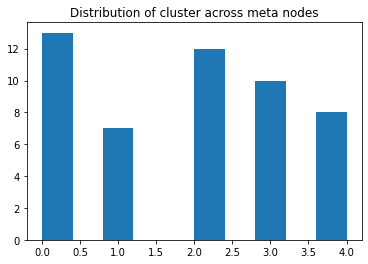

In [132]:
def get_histogram(node_type,
                    attribute, 
                    bolt, 
                    auth,
                    plot_type = 'histogram'): 
    
    gds = GraphDataScience('bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

    #make a graph projection (/get all the relevant nodes)
    try: # get a projection of the graph 
        G,_ = gds.graph.project('make_hist',
                    {node_type: {"properties": attribute}}, ### does not work because property is a string???  and it only lets me use strings to create node properties???
                    ['has_sorensen']
                )
    except: 
        G = gds.graph.get('make_hist')
        G.drop()
        G,_ = gds.graph.project('make_hist',
                            {node_type: {"properties": attribute}}, ### does not work because property is a string???  and it only lets me use strings to create node properties???
                            ['has_sorensen']
                        )

    print(G.node_properties())

    # collect the attribute
    property_series = gds.graph.streamNodeProperty(G, attribute)

    if plot_type == 'histogram':

        plt.hist(property_series['propertyValue'])
        plt.title(f"Distribution of {attribute} across {node_type} nodes")

    if plot_type == "density":
        # plot a histogram plot of the page-rank distribution
        sns.kdeplot(gds.pageRank.stream(G)['score'], label = f"{prob_scale}")
        plt.title(f"Distribution of {attribute} across {node_type} nodes")
    

    # delete the graph projection
    G.drop()

    plt.show()


get_histogram("meta", 
            'cluster', 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

## Generate Nodes (function) (bulky graphql queries)

In [219]:
def build_mutations(node_count, company_names, mu_poisson):

    """
    func:   build_mutations
            Generates a mutation string to pass to graphQL API that generates a node
    """

    #define categories of data usage
    categories = ["Personalised Ads", "Social Media", "Cookies", "purpose 1", "purpose 2", "purpose 3", "purpose 4", "purpose 5"]

    #empty list with mutations
    mutations = []

    #make node_count mutations
    for i in range(node_count):
        # initialize
        output_string = 'mutation { createtilts( input: [ { '
        
        # add tilt and meta data
        output_string += f'_id:{{create:[{{oid: "{rd.randrange(1000)}"}}]}}meta:{{create:[{{_id: "{i}", name: "{company_names["Company"][i]}", created: "{time.strftime("%Y:%m:%d, %H:%M:%S")}", modified: "None", version: "1", language: "en", status: "active", url: "{company_names["Website"][i]}", _hash:"some hash" }}]}}' 
        
        output_string += 'dataDisclosed:{create:['
        for d in range(poisson.rvs(mu_poisson, size=1)[0]):
        # add dataDisclosed 
            output_string += f'{{_id: "{i}_{d}", category: "{rd.choice(categories)}", purposes:{{create:[{{}}]}}legalBases:{{create:[{{}}]}}legitimateInterests:{{create:[{{reasoning: "Lorem Ipsum", exists: "True"}}]}}recipients:{{create:[{{name: "{company_names["Company"][rd.randrange(500)]}", country: "None", division: "None", address: "None", representative:{{create:[{{name: "None", email: "None", phone: "None"}}]}}category: "None"}}]}}storage:{{create:[{{}}]}}nonDisclosure:{{create:[{{consequences: "Lorem Ipsum", legalRequirement: "False", contractualRegulation: "True", obligationToProvide: "False"}}]}}}}'

        # complete string
        output_string += ']} }] ) {tilts {meta { name } } } }'

        mutations.append(output_string)

    return mutations

In [220]:
#hyperparameters

#number of nodes
no_nodes_hyp = 30

#average number of recipients in data disclosed (drawn from poisson)
mu_poisson_hyp = 2


build_mutations(1, fortune_500, mu_poisson= mu_poisson_hyp)

['mutation { createtilts( input: [ { _id:{create:[{oid: "220"}]}meta:{create:[{_id: "0", name: "Walmart", created: "2022:08:23, 09:44:39", modified: "None", version: "1", language: "en", status: "active", url: "https://www.walmart.com/", _hash:"some hash" }]}dataDisclosed:{create:[{_id: "0_0", category: "Social Media", purposes:{create:[{}]}legalBases:{create:[{}]}legitimateInterests:{create:[{reasoning: "Lorem Ipsum", exists: "True"}]}recipients:{create:[{name: "DXC Technology", country: "None", division: "None", address: "None", representative:{create:[{name: "None", email: "None", phone: "None"}]}category: "None"}]}storage:{create:[{}]}nonDisclosure:{create:[{consequences: "Lorem Ipsum", legalRequirement: "False", contractualRegulation: "True", obligationToProvide: "False"}]}}{_id: "0_1", category: "Social Media", purposes:{create:[{}]}legalBases:{create:[{}]}legitimateInterests:{create:[{reasoning: "Lorem Ipsum", exists: "True"}]}recipients:{create:[{name: "Cincinnati Financial", c

In [306]:
fortune_500

,Unnamed: 0,Rank,Company,Website
0,0,1,Walmart,https://www.walmart.com/
1,1,2,Amazon,https://www.amazon.com/
2,2,3,Apple,https://www.apple.com/
3,3,4,CVS Health,https://www.cvshealth.com/
4,4,5,UnitedHealth Group,https://www.unitedhealthgroup.com/
...,...,...,...,...
495,495,496,Hasbro,https://shop.hasbro.com/
496,496,497,Roper Technologies,https://www.ropertech.com/
497,497,498,ARKO,https://www.arkocorp.com/
498,498,499,Frontier Communications,https://frontier.com/


### Upload to NEO4J

In [207]:
from tqdm import tqdm
import re
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# console = Console()

sample_transport=RequestsHTTPTransport(
    url='http://localhost:4001/graphql',
    use_json=True,
    headers={
        "Content-type": "application/json",
    },
    verify=False
)

client = Client(
    #execute_timeout=20,
    transport=sample_transport,
    fetch_schema_from_transport=True,
)


successes = 0
for i, query_string in enumerate(tqdm(build_mutations(50, fortune_500))):
    #print("Query String: ", query_string)
    try:
        query = gql(query_string)
        #client.execute(query)
        successes += 1
    except Exception as syn:
        print(syn)
        print("Error With Tilt No.", i)

print("Successfully Uploaded:", 100*(successes/(i+1)), "per. of tilts")

100%|██████████| 50/50 [00:00<00:00, 272.04it/s]

Successfully Uploaded: 100.0 per. of tilts
